In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

import numpy as np
import random

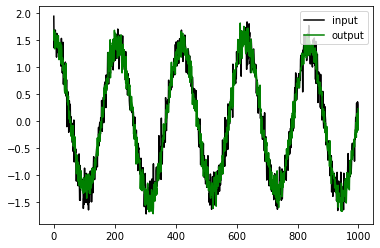

In [2]:
timestep_in = 40 
timestep_out = 30 
features_in = 1
features_out = 1
length = 1000
t = np.linspace(0, 10, length)
ts_input = np.cos(t) / 3 + 5 * np.cos(t*3) + 0.7 * np.random.standard_normal(size=length)
ts_output = np.cos(t) / 5 + 3 * np.cos(t*3) + 0.3 * np.random.standard_normal(size=length)

ts_input_norm = (ts_input - np.mean(ts_input)) / np.std(ts_input)
ts_output_norm = (ts_output - np.mean(ts_output)) / np.std(ts_output)
plt.plot(ts_input_norm, 'black', label = 'input')
plt.plot(ts_output_norm,'green', label = 'output')

plt.legend()

In [3]:
train_size = int(len(ts_input) * 0.8)
test_size = len(ts_input) - train_size

train_in, test_in = ts_input_norm[0:train_size], ts_input_norm[train_size:len(ts_input)]
train_out, test_out = ts_output_norm[0:train_size], ts_output_norm[train_size:len(ts_input)]

seq_len = max(timestep_in, timestep_out)
def create_dataset():
    train_in_data, train_out_data = [], []
    for i in range(500):
        rand_ind_train = random.randint(0, len(train_in) - seq_len)
        in_seq = ts_input_norm[rand_ind_train:rand_ind_train+timestep_in]
        out_seq = ts_output_norm[rand_ind_train:rand_ind_train+timestep_out]
        train_in_data.append(in_seq)
        train_out_data.append(out_seq)

    test_in_data, test_out_data = [], []   
    for i in range(5):
        rand_ind_test = random.randint(0, len(test_in) - seq_len)
        in_seq = ts_input_norm[rand_ind_test:rand_ind_test+timestep_in]
        out_seq = ts_output_norm[rand_ind_test:rand_ind_test+timestep_out]
        test_in_data.append(in_seq)
        test_out_data.append(out_seq)
    return np.array(train_in_data), np.array(train_out_data), np.array(test_in_data), np.array(test_out_data)

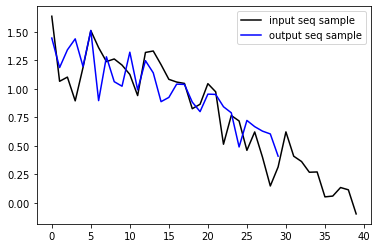

In [7]:
train_in_data, train_out_data, test_in_data, test_out_data = create_dataset()
plt.plot(train_in_data[0], 'black', label = 'input seq sample')
plt.plot(train_out_data[0], 'b', label = 'output seq sample')
plt.legend()
train_in_data = np.reshape(train_in_data, (train_in_data.shape[0], timestep_in, features_in))
train_out_data = np.reshape(train_out_data, (train_in_data.shape[0], timestep_out, features_out))

test_in_data = np.reshape(test_in_data, (test_in_data.shape[0], timestep_in, features_in))
test_out_data = np.reshape(test_out_data, (test_in_data.shape[0], timestep_out, features_out))

In [9]:
units = 128

encoder_inputs = keras.Input(shape=(timestep_in, features_in))
encoder = keras.layers.LSTM(units, return_sequences=False, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = keras.Input(shape=(timestep_out, features_out))
decoder_lstm =  keras.layers.LSTM(units, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(features_out, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [10]:
model.compile(optimizer='adam', loss='mse')
decoder_inputs = np.zeros(train_out_data.shape)

set_callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]

model.fit([train_in_data, decoder_inputs], train_out_data,
          epochs=100, batch_size=64, validation_split=0.2, callbacks = set_callbacks, verbose=2)

Epoch 1/100
7/7 - 1s - loss: 0.8573 - val_loss: 0.4844
Epoch 2/100
7/7 - 0s - loss: 0.3070 - val_loss: 0.2272
Epoch 3/100
7/7 - 0s - loss: 0.1867 - val_loss: 0.1750
Epoch 4/100
7/7 - 0s - loss: 0.1749 - val_loss: 0.1607
Epoch 5/100
7/7 - 0s - loss: 0.1347 - val_loss: 0.1430
Epoch 6/100
7/7 - 0s - loss: 0.1163 - val_loss: 0.1344
Epoch 7/100
7/7 - 0s - loss: 0.0984 - val_loss: 0.1173
Epoch 8/100
7/7 - 0s - loss: 0.0815 - val_loss: 0.0996
Epoch 9/100
7/7 - 0s - loss: 0.0847 - val_loss: 0.0943
Epoch 10/100
7/7 - 0s - loss: 0.0743 - val_loss: 0.0688
Epoch 11/100
7/7 - 0s - loss: 0.0584 - val_loss: 0.0567
Epoch 12/100
7/7 - 0s - loss: 0.0436 - val_loss: 0.0368
Epoch 13/100
7/7 - 0s - loss: 0.0305 - val_loss: 0.0324
Epoch 14/100
7/7 - 0s - loss: 0.0342 - val_loss: 0.0346
Epoch 15/100
7/7 - 0s - loss: 0.0297 - val_loss: 0.0262
Epoch 16/100
7/7 - 0s - loss: 0.0280 - val_loss: 0.0247
Epoch 17/100
7/7 - 0s - loss: 0.0268 - val_loss: 0.0283
Epoch 18/100
7/7 - 0s - loss: 0.0273 - val_loss: 0.0267
E

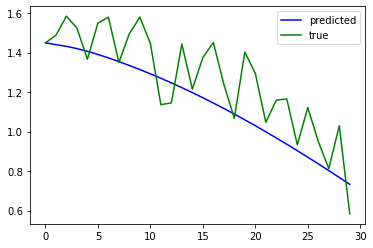

In [13]:
decoder_inputs = np.zeros(test_out_data.shape)
y_pred = model.predict([test_in_data, decoder_inputs])
plt.plot(y_pred[0], 'b', label = 'predicted')
plt.plot(test_out_data[0], 'g', label = 'true')

plt.legend()